Device: cuda
Log-probs shape (time X batch X channels): 128x256x32
Built-in CTC loss fwd 0.0037965774536132812 bwd 0.9368338584899902
Custom CTC loss fwd 0.19373488426208496 bwd 0.1380176544189453
Custom loss matches: True
Grad matches: True
CE grad matches: True


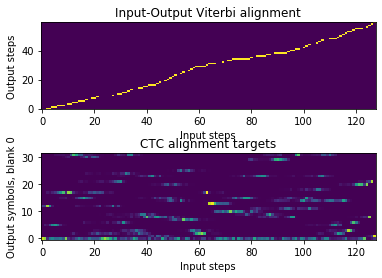

In [1]:
import time
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import ctc

T, B, C = 128, 256, 32
t = T // 2 - 4
blank = 0
device = 'cuda'
seed = 1
atol = 1e-3
for set_seed in [torch.manual_seed] + ([torch.cuda.manual_seed_all] if device == 'cuda' else []):
	set_seed(seed)
tictoc = lambda: (device == 'cuda' and torch.cuda.synchronize()) or time.time()

logits = torch.randn(T, B, C, device = device).requires_grad_()
targets = torch.randint(blank + 1, C, (B, t), dtype = torch.long, device = device)
input_lengths = torch.full((B,), T, dtype = torch.long, device = device)
target_lengths = torch.full((B,), t, dtype = torch.long, device = device)
log_probs = logits.log_softmax(dim = -1)

print('Device:', device)
print('Log-probs shape (time X batch X channels):', 'x'.join(map(str, log_probs.shape)))

tic = tictoc()
builtin_ctc = F.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none')
toc = tictoc()
builtin_ctc_grad, = torch.autograd.grad(builtin_ctc.sum(), logits, retain_graph = True)
print('Built-in CTC loss', 'fwd', toc - tic, 'bwd', tictoc() - toc)

tic = tictoc()
custom_ctc = ctc.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none')
toc = tictoc()
custom_ctc_grad, = torch.autograd.grad(custom_ctc.sum(), logits, retain_graph = True)
print('Custom CTC loss', 'fwd', toc - tic, 'bwd', tictoc() - toc)

ce_alignment_targets = ctc.ctc_alignment_targets(log_probs, targets, input_lengths, target_lengths, blank = 0)
ce_ctc = -ce_alignment_targets * log_probs
ce_ctc_grad, = torch.autograd.grad(ce_ctc.sum(), logits, retain_graph = True)

print('Custom loss matches:', torch.allclose(builtin_ctc, custom_ctc, atol = atol))
print('Grad matches:', torch.allclose(builtin_ctc_grad, custom_ctc_grad, atol = atol))
print('CE grad matches:', torch.allclose(builtin_ctc_grad, ce_ctc_grad, atol = atol))

alignment = ctc.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none', alignment = True)
a = alignment[:, 0, :target_lengths[0]]
plt.subplot(211)
plt.title('Input-Output Viterbi alignment')
plt.imshow(a.t().cpu(), origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel('Output steps')
plt.subplot(212)
plt.title('CTC alignment targets')
a = ce_alignment_targets[:, 0, :]
plt.imshow(a.t().cpu(), origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel(f'Output symbols, blank {blank}')
plt.subplots_adjust(hspace = 0.5)
plt.savefig('alignment.png')

In [12]:
target_lengths

tensor([60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 

In [10]:
print(t)
print(alignment.size())
a = alignment[:, 0, :target_lengths[0]]
print(a.size())
print(logits.size())

60
torch.Size([128, 256, 61])
torch.Size([128, 60])
torch.Size([128, 256, 32])


In [2]:
logits #= torch.randn(T, B, C, device = device).requires_grad_()
# torch.randn(*size, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) → Tensor

tensor([[[-2.9628e-01,  2.6764e+00, -1.4085e-01,  ...,  1.8636e-01,
          -1.5413e+00,  1.3425e+00],
         [ 5.7348e-01,  2.7806e-02,  1.2966e-02,  ..., -8.5268e-01,
           3.5594e-01, -1.3682e+00],
         [-1.4363e+00, -1.5196e+00,  2.2909e-01,  ..., -4.7396e-01,
          -1.3142e+00, -7.8856e-01],
         ...,
         [-1.4285e+00,  2.8120e-01, -1.5915e+00,  ..., -4.0258e-01,
          -2.5593e-01, -3.3626e-02],
         [ 4.7650e-01, -1.7647e+00, -4.2770e-01,  ..., -1.2805e+00,
          -1.0275e+00, -5.2449e-01],
         [ 7.1077e-01, -5.4442e-02, -1.6914e-01,  ...,  1.7871e+00,
           2.7135e+00, -1.6598e-02]],

        [[ 9.2974e-01,  5.7184e-01,  2.0154e-01,  ...,  7.0909e-01,
          -1.4973e+00, -1.4601e+00],
         [-7.4001e-01,  5.3839e-01, -4.7201e-01,  ...,  4.8079e-01,
          -6.8517e-02,  3.3242e-01],
         [ 1.3733e+00, -4.0550e-01, -1.4875e+00,  ...,  6.1299e-01,
          -9.2470e-01, -1.7578e+00],
         ...,
         [-1.1940e+00,  8

In [3]:
targets #= torch.randint(blank + 1, C, (B, t), dtype = torch.long, device = device)
# randint(low=0, high, size, *, generator=None, out=None,

tensor([[12,  5, 17,  ...,  8, 21,  1],
        [ 3, 22,  2,  ..., 15, 20, 26],
        [10, 19, 23,  ..., 28, 18,  1],
        ...,
        [13, 27, 28,  ..., 21, 31, 30],
        [19, 24, 15,  ...,  2, 19, 12],
        [ 4,  5, 21,  ..., 23,  9, 13]], device='cuda:0')

In [13]:
print(targets.size())

torch.Size([256, 60])


In [14]:
a = ce_alignment_targets[:, 0, :]
a.cpu().t()


tensor([[ 8.4674e-01,  7.6278e-01,  1.1277e-01,  ...,  1.0386e-02,
          5.4665e-02,  1.3087e-01],
        [ 5.1707e-06,  7.0781e-07, -5.5879e-07,  ...,  4.8860e-02,
          1.4171e-01,  8.6913e-01],
        [ 3.0920e-07,  4.8801e-07, -3.5390e-07,  ...,  8.3447e-07,
          2.4773e-07,  1.4901e-08],
        ...,
        [ 4.2841e-07,  8.1211e-07, -1.3672e-06,  ...,  2.3097e-07,
          1.2666e-07,  1.4901e-08],
        [ 7.6136e-08,  8.9407e-08, -1.1995e-06,  ...,  7.0781e-08,
          5.6811e-08,  5.5879e-09],
        [ 1.3635e-06,  9.3132e-08, -5.4017e-07,  ...,  1.4156e-07,
          5.4017e-08,  9.3132e-09]])

tensor([[0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
tensor([[ 8.4674e-01,  7.6278e-01,  1.1277e-01,  3.6146e-01,  4.2714e-01],
        [ 5.1707e-06,  7.0781e-07, -5.5879e-07, -7.4133e-07, -2.6599e-06],
        [ 3.0920e-07,  4.8801e-07, -3.5390e-07, -4.1537e-07, -2.7567e-07],
        [ 1.5320e-07,  9.8720e-08, -1.5041e-07, -2.3693e-06, -7.2457e-07],
        [ 4.7684e-07,  1.8068e-07, -6.4820e-07, -6.0163e-07, -3.3379e-06],
        [ 2.6822e-07,  6.8945e-02,  3.7062e-02,  1.7848e-01,  4.3889e-01],
        [ 8.3121e-08,  1.2107e-07, -3.8650e-07, -1.4678e-06, -8.6054e-07],
        [ 3.8147e-06,  4.8429e-07, -1.9465e-07, -7.3342e-08, -1.2256e-06],
        [ 3.4925e-07,  6.7055e-07, -1.2107e-07, -8.6054e-07, -2.7474e-07],
        [ 2.1886e-08,  4.5821e-07, -3.2112e-06, -2.0862e-06, -4.7684e-06],
        [ 2.4401e-07,  1.6950e-07, -5.0291e-07, -6.5938e-07, -6.2026e-07],
        [ 7.2084e-07,  5.7369e-07, -8.1956e-07, -1.983

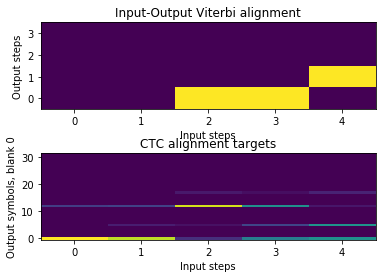

In [28]:
alignment = ctc.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none', alignment = True)
a = alignment[:, 0, :target_lengths[0]]
plt.subplot(211)
plt.title('Input-Output Viterbi alignment')
plt.imshow(a.t().cpu()[:4,:5], origin = 'lower', aspect = 'auto')
print(a.t().cpu()[:4,:5])
plt.xlabel('Input steps')
plt.ylabel('Output steps')
plt.subplot(212)
plt.title('CTC alignment targets')
a = ce_alignment_targets[:, 0, :]
plt.imshow(a.t().cpu()[:,:5], origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel(f'Output symbols, blank {blank}')
plt.subplots_adjust(hspace = 0.5)
plt.savefig('alignment.png')
print(a.t().cpu()[:14,:5])
print(targets[:5,0])

In [ ]:
targets